In [23]:
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import preprocessing
from sklearn.impute import SimpleImputer
from sklearn.manifold import MDS
from math import floor
import seaborn as sns

In [24]:
# Lectura de datos y funcion de normalizacion
def norm_to_zero_one(df):
    return (df - df.min()) * 1.0 / (df.max() - df.min())

datos = pd.read_csv('datos_hogar_2020.csv')

In [25]:
[(name, type) for (name, type) in zip(datos.columns, datos.dtypes)]

[('DB030', dtype('int64')),
 ('DB040', dtype('O')),
 ('DB040_F', dtype('int64')),
 ('DB060', dtype('int64')),
 ('DB060_F', dtype('int64')),
 ('DB090', dtype('int64')),
 ('DB090_F', dtype('int64')),
 ('DB100', dtype('int64')),
 ('DB100_F', dtype('int64')),
 ('HB050', dtype('int64')),
 ('HB050_F', dtype('int64')),
 ('HB060', dtype('int64')),
 ('HB060_F', dtype('int64')),
 ('HB070', dtype('float64')),
 ('HB070_F', dtype('int64')),
 ('HB080', dtype('int64')),
 ('HB080_F', dtype('int64')),
 ('HB090', dtype('float64')),
 ('HB090_F', dtype('int64')),
 ('HB100', dtype('float64')),
 ('HB100_F', dtype('int64')),
 ('HY020', dtype('float64')),
 ('HY020_F', dtype('int64')),
 ('HY022', dtype('float64')),
 ('HY022_F', dtype('int64')),
 ('HY023', dtype('float64')),
 ('HY023_F', dtype('int64')),
 ('HY030N', dtype('float64')),
 ('HY030N_F', dtype('int64')),
 ('HY040N', dtype('float64')),
 ('HY040N_F', dtype('int64')),
 ('HY050N', dtype('float64')),
 ('HY050N_F', dtype('int64')),
 ('HY060N', dtype('float

In [26]:
# Se pueden reemplazar los valores desconocidos por un número
# datos = datos.replace(np.NaN,0)

# O imputar, por ejemplo con la media
def imputar_valores_perdidos():
    for col in datos:
        if col != 'DB040':
            datos[col].fillna(datos[col].mean(), inplace=True)
            
imputar_valores_perdidos()

In [27]:
# Seleccionar casos
subset = datos.loc[(datos['HY030N']>0) & (datos['HC030_F']==1)] #solo los que se conoce el alquiler imputado y gasto en transporte público

# Seleccionar variables de interés para clustering
# renombramos las variables por comodidad
subset=subset.rename(columns={"HY020": "renta", "HY030N": "alquiler_imputado", "HC010": "alimentacion_in", "HC030": "transporte"})
usadas = ['renta','alquiler_imputado','alimentacion_in','transporte']

n_var = len(usadas)
X = subset[usadas]

print(X)

         renta  alquiler_imputado  alimentacion_in  transporte
2      24500.0            5780.04       200.000000       100.0
6      30030.0            8626.47       300.000000        28.0
17     11420.0            2548.47       120.000000        20.0
25     12311.8            5975.87       400.000000        15.0
32     13537.1            7096.47       400.000000        20.0
...        ...                ...              ...         ...
15011  36804.0            3822.03       350.000000       100.0
15015  30479.8            6763.50       459.506413        12.0
15035  27481.5            3935.42       300.000000        12.0
15040  24702.6            5201.36       500.000000         1.0
15041   5564.1            3593.04       250.000000        40.0

[3322 rows x 4 columns]


In [28]:
# eliminar outliers como aquellos casos fuera de 1.5 veces el rango intercuartil
def eliminar_outliers(X):
    Q1 = X.quantile(0.25)
    Q3 = X.quantile(0.75)
    IQR = Q3 - Q1
    return X[~((X < (Q1 - 1.5 * IQR)) |(X > (Q3 + 1.5 * IQR))).any(axis=1)]


X = eliminar_outliers(X)
    
# normalizamos
X_normal = X.apply(norm_to_zero_one)

In [29]:
def kmeans(X_normal, n_clusters_arg=5, n_init_arg=5, random_state_arg=123456):
    print('----- Ejecutando k-Means',end='')
    k_means = KMeans(init='k-means++', n_clusters=n_clusters_arg, n_init=n_init_arg, random_state=random_state_arg)
    t = time.time()
    cluster_predict = k_means.fit_predict(X_normal,subset['DB090']) #se usa DB090 como peso para cada objeto (factor de elevación)
    tiempo = time.time() - t
    print(": {:.2f} segundos, ".format(tiempo), end='')
    
    return k_means, cluster_predict
    
    
k_means, cluster_predict = kmeans(X_normal)

----- Ejecutando k-Means: 0.73 segundos, 

In [30]:
# Medidas

def metrica_CH(X_normal, cluster_predict):
    metric_CH = metrics.calinski_harabasz_score(X_normal, cluster_predict)
    print("Calinski-Harabasz Index: {:.3f}, ".format(metric_CH), end='')
    return metric_CH

metrica_CH(X_normal, cluster_predict)

# Esto es opcional, el cálculo de Silhouette puede consumir mucha RAM.
# Si son muchos datos, digamos más de 10k, se puede seleccionar una muestra, p.ej., el 20%
def metrica_SC(X_normal, cluster_predict):
    muestra_silhoutte = 0.2 if (len(X) > 10000) else 1.0

    metric_SC = metrics.silhouette_score(X_normal, cluster_predict, metric='euclidean', sample_size=floor(muestra_silhoutte*len(X)), random_state=123456)
    print("Silhouette Coefficient: {:.5f}".format(metric_SC))
    return metric_SC

metrica_SC(X_normal, cluster_predict)

# se convierte la asignación de clusters a DataFrame
clusters = pd.DataFrame(cluster_predict,index=X.index,columns=['cluster'])

def tam_clusters(clusters):
    print("Tamaño de cada cluster:")
    size=clusters['cluster'].value_counts()
    tams_clusters = []
    for num,i in size.iteritems():
       print('%s: %5d (%5.2f%%)' % (num,i,100*i/len(clusters)))
       tams_clusters.append(i)
    return tams_clusters, size

tam_clusters, size = tam_clusters(clusters)

def calcular_centros(X, k_means):
    centers = pd.DataFrame(k_means.cluster_centers_,columns=list(X))
    centers_desnormal = centers.copy()

    # se convierten los centros a los rangos originales antes de normalizar
    for var in list(centers):
        centers_desnormal[var] = X[var].min() + centers[var] * (X[var].max() - X[var].min())
        
    return centers, centers_desnormal

centers, centers_desnormal = calcular_centros(X, k_means)

Calinski-Harabasz Index: 860.747, Silhouette Coefficient: 0.21802
Tamaño de cada cluster:
2:   824 (28.97%)
0:   582 (20.46%)
4:   576 (20.25%)
3:   471 (16.56%)
1:   391 (13.75%)


---------- Heatmap...


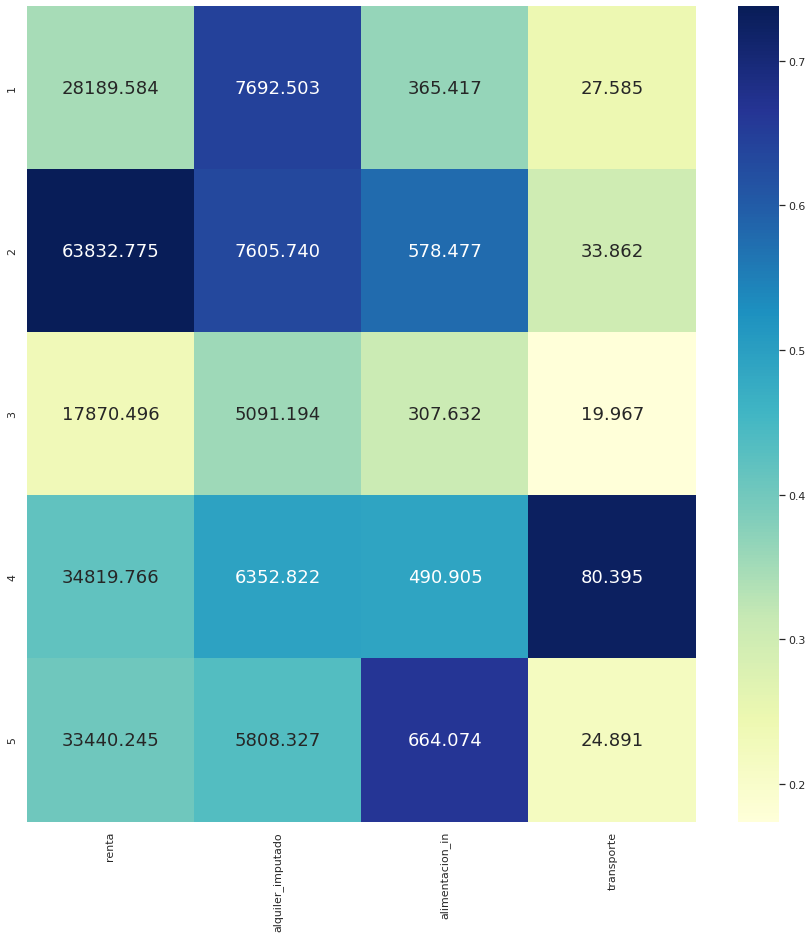

In [31]:
# heatmap
def heatmap(centers, centers_desnormal, size):
    print("---------- Heatmap...")
    centers.index += 1
    hm = sns.heatmap(centers, cmap="YlGnBu", annot=centers_desnormal, annot_kws={"fontsize":18}, fmt='.3f')
    hm.set_ylim(len(centers),0)
    hm.figure.set_size_inches(15,15)
    #hm.figure.savefig("centroides.png")
    centers.index -= 1

    k = len(size)
    colors = sns.color_palette(palette='Paired', n_colors=k, desat=None)
    
    
heatmap(centers, centers_desnormal, size)

---------- Scatter matrix...


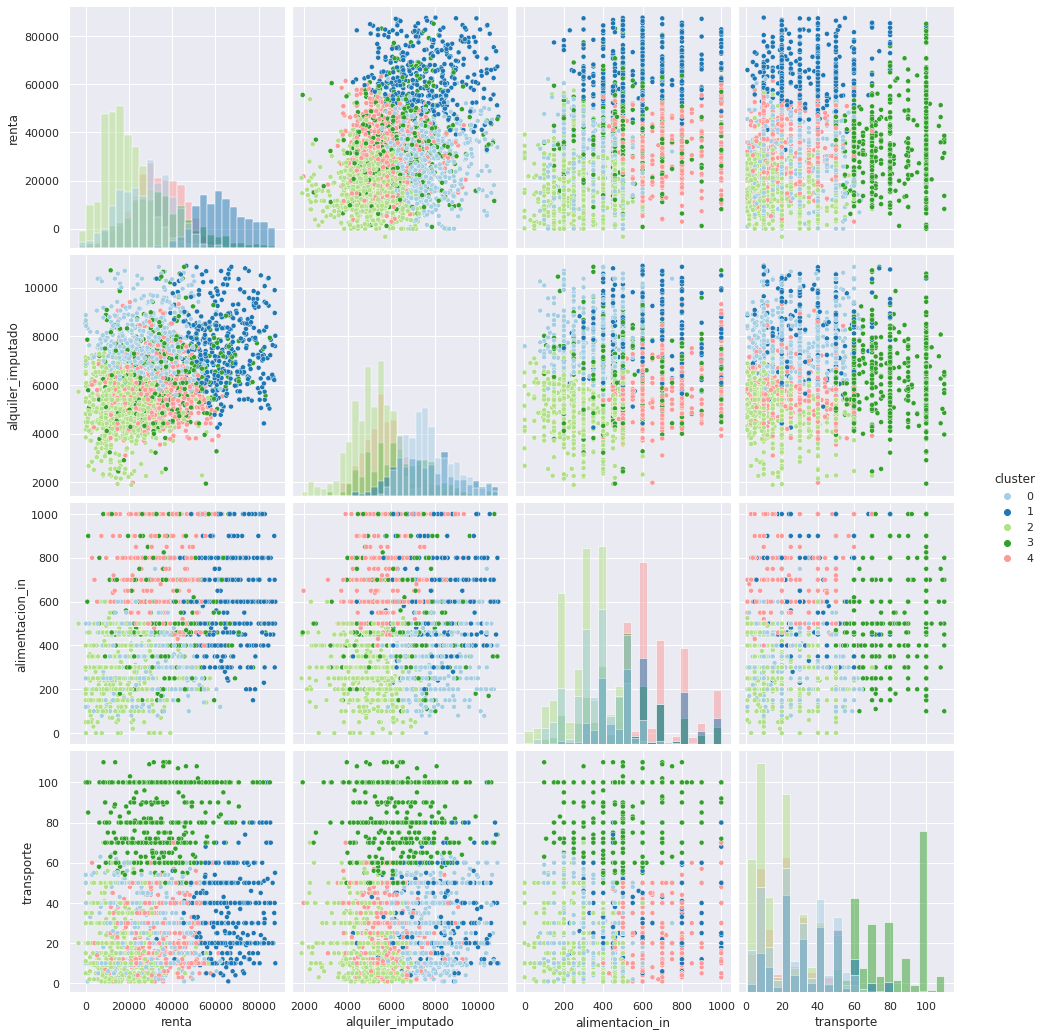

In [32]:
# Scatter matrix
def scatter_matrix(X, clusters, size):
    print("---------- Scatter matrix...")
    # se añade la asignación de clusters como columna a X
    X_kmeans = pd.concat([X, clusters], axis=1)
    k = len(size)
    colors = sns.color_palette(palette='Paired', n_colors=k, desat=None)
    #'''
    sns.set()
    variables = list(X_kmeans)
    variables.remove('cluster')
    sns_plot = sns.pairplot(X_kmeans, vars=variables, hue="cluster", palette=colors, plot_kws={"s": 25}, diag_kind="hist") #en hue indicamos que la columna 'cluster' define los colores
    sns_plot.fig.subplots_adjust(wspace=.03, hspace=.03)
    sns_plot.fig.set_size_inches(15,15)
    #sns_plot.savefig("scatter.png")
    #'''
    
scatter_matrix(X, clusters, size)

---------- Boxplots...


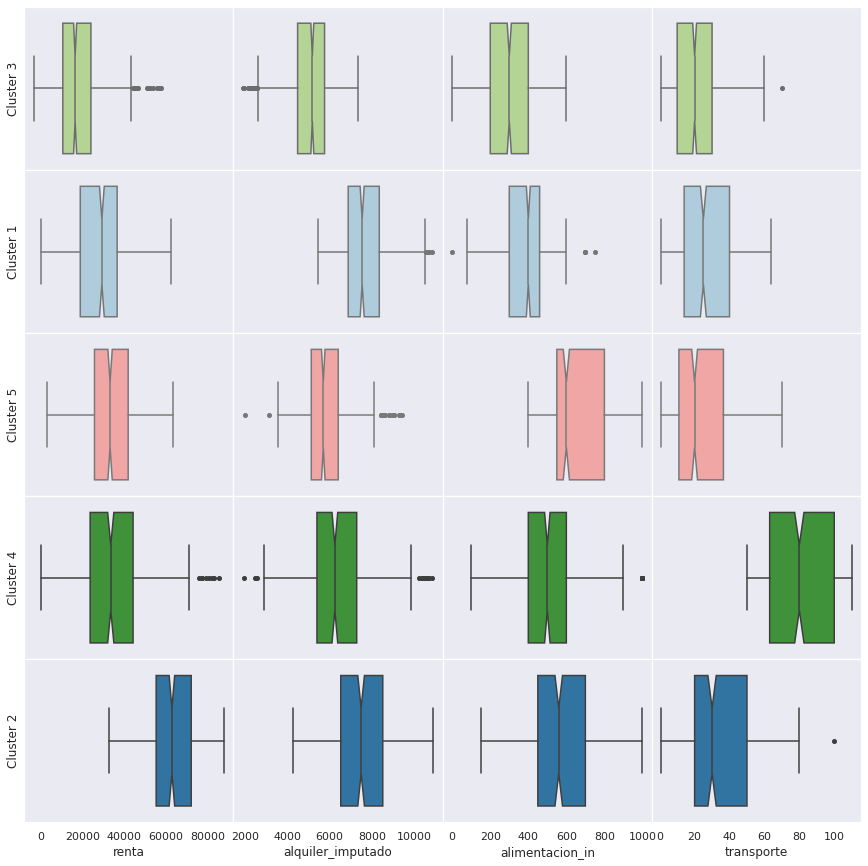

In [37]:
# Boxplot

def boxplot(size):
    print("---------- Boxplots...")
    
    X_kmeans = pd.concat([X, clusters], axis=1)
    k = len(size)
    colors = sns.color_palette(palette='Paired', n_colors=k, desat=None)
    
    fig, axes = plt.subplots(k, n_var, sharey=True,figsize=(15,15))
    fig.subplots_adjust(wspace=0,hspace=0)

    centers_sort = centers.sort_values(by=['renta']) #ordenamos por renta para el plot

    rango = []
    for j in range(n_var):
       rango.append([X_kmeans[usadas[j]].min(),X_kmeans[usadas[j]].max()])

    for i in range(k):
        c = centers_sort.index[i]
        dat_filt = X_kmeans.loc[X_kmeans['cluster']==c]
        for j in range(n_var):
            # Esto sale mal si quito el comentario y comento lo sigueinte al profe le sale mal y nos abe por que xd
            #ax = sns.kdeplot(x=dat_filt[usadas[j]], label="", shade=True, color=colors[c], ax=axes[i,j])
            ax = sns.boxplot(x=dat_filt[usadas[j]], notch=True, color=colors[c], flierprops={'marker':'o','markersize':4}, ax=axes[i,j])

            if (i==k-1):
                axes[i,j].set_xlabel(usadas[j])
            else:
                axes[i,j].set_xlabel("")

            if (j==0):
               axes[i,j].set_ylabel("Cluster "+str(c+1))
            else:
                axes[i,j].set_ylabel("")

            axes[i,j].set_yticks([])
            axes[i,j].grid(axis='x', linestyle='-', linewidth='0.2', color='gray')
            axes[i,j].grid(axis='y', b=False)

            ax.set_xlim(rango[j][0]-0.05*(rango[j][1]-rango[j][0]),rango[j][1]+0.05*(rango[j][1]-rango[j][0]))

    fig.set_size_inches(15,15)
    #fig.savefig("boxplots.png")
    
boxplot(size)

---------- MDS...


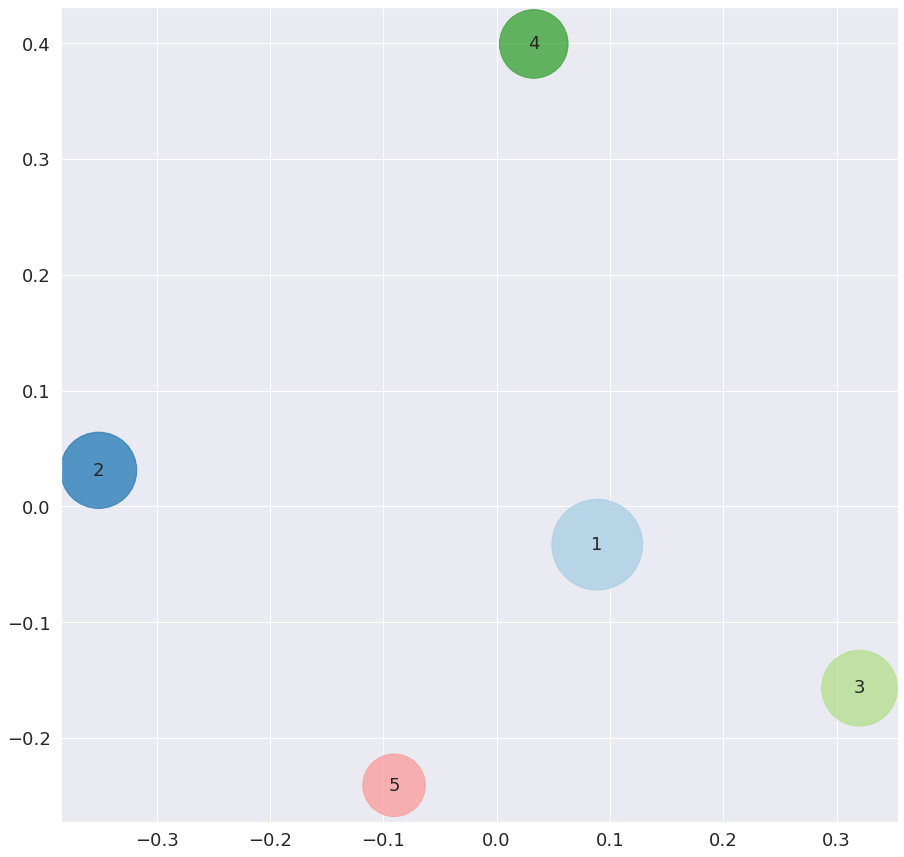

In [36]:
# MDS
def graf_MDS(centers, size):
    print("---------- MDS...")
    X_kmeans = pd.concat([X, clusters], axis=1)
    k = len(size)
    colors = sns.color_palette(palette='Paired', n_colors=k, desat=None)
    
    mds = MDS(random_state=123456)
    centers_mds = mds.fit_transform(centers)
    fig=plt.figure(4)
    plt.scatter(centers_mds[:,0], centers_mds[:,1], s=size*10, alpha=0.75, c=colors)
    for i in range(k):
        plt.annotate(str(i+1),xy=centers_mds[i],fontsize=18,va='center',ha='center')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    fig.set_size_inches(15,15)
    #plt.savefig("mds.png")
    
graf_MDS(centers, size)